#### Anthony Wilson 
#### Milestone 4
#### 5/17/2020

In [1]:
import pandas as pd
import regex as re
import numpy as np
from bs4 import BeautifulSoup
from multiprocessing import Pool
import urllib3
import requests
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import string

In [2]:
# we need to pull in all the country data from the api
def getCovidApiData(get = 'all'):
    url = 'https://covid-api.com/'
    resp = requests.get(url + get)
    df = pd.DataFrame(resp.json())
    return df 

In [3]:
#creating dataset for api
covidapi = getCovidApiData()
covidapi.head()

Country CountryCode Province City CityCode    Lat    Lon  Confirmed  \
0  Afghanistan          AF                         33.94  67.71          0   
1  Afghanistan          AF                         33.94  67.71          0   
2  Afghanistan          AF                         33.94  67.71          0   
3  Afghanistan          AF                         33.94  67.71          0   
4  Afghanistan          AF                         33.94  67.71          0   

   Deaths  Recovered  Active                  Date  
0       0          0       0  2020-01-22T00:00:00Z  
1       0          0       0  2020-01-23T00:00:00Z  
2       0          0       0  2020-01-24T00:00:00Z  
3       0          0       0  2020-01-25T00:00:00Z  
4       0          0       0  2020-01-26T00:00:00Z

* Replace Headers

In [4]:
#update a few names, but mostly just lower case the first letter
column_update = {'Country': 'country',
                'CountryCode':'countryCode',
                'Province': 'province',
                'City':'city',
                'CityCode':'cityCode',
                'Lat':'latitude',
                'Lon':'longitude',
                'Confirmed':'confirmed',
                'Deaths':'deaths',
                'Recovered':'recovered',
                'Active':'active',
                'Date':'date'}

In [5]:
covidapi.columns =covidapi.columns.map(column_update) # mapping new column names

In [6]:
covidapi.columns

Index(['country', 'countryCode', 'province', 'city', 'cityCode', 'latitude',
       'longitude', 'confirmed', 'deaths', 'recovered', 'active', 'date'],
      dtype='object')

* Format data into a more readable format

In [7]:
# since the dates are all stored in as a timestamp we can probably convert them to be dates
covidapi.date.value_counts().sort_index()

2020-01-22T00:00:00Z    3516
2020-01-23T00:00:00Z    3516
2020-01-24T00:00:00Z    3516
2020-01-25T00:00:00Z    3516
2020-01-26T00:00:00Z    3516
                        ... 
2020-05-13T00:00:00Z    3516
2020-05-14T00:00:00Z    3516
2020-05-15T00:00:00Z    3516
2020-05-16T00:00:00Z    3516
2020-05-17T00:00:00Z    3516
Name: date, Length: 117, dtype: int64

In [8]:
#these are just string dates so we could drop the first part using the slice function
type(covidapi.date[0])

str

In [9]:
covidapi['date'] = covidapi.date.str.slice(stop = 10)

In [10]:
covidapi.head()

country countryCode province city cityCode latitude longitude  \
0  Afghanistan          AF                           33.94     67.71   
1  Afghanistan          AF                           33.94     67.71   
2  Afghanistan          AF                           33.94     67.71   
3  Afghanistan          AF                           33.94     67.71   
4  Afghanistan          AF                           33.94     67.71   

   confirmed  deaths  recovered  active        date  
0          0       0          0       0  2020-01-22  
1          0       0          0       0  2020-01-23  
2          0       0          0       0  2020-01-24  
3          0       0          0       0  2020-01-25  
4          0       0          0       0  2020-01-26

In [11]:
#convert dates to python datetime
covidapi['date'] = pd.to_datetime(covidapi['date'])

In [12]:
#check other data points makes sure we don't need to convert anything else
covidapi.dtypes

country                object
countryCode            object
province               object
city                   object
cityCode               object
latitude               object
longitude              object
confirmed               int64
deaths                  int64
recovered               int64
active                  int64
date           datetime64[ns]
dtype: object

In [13]:
#setting lat and long to numeric values 
covidapi['latitude'] = pd.to_numeric(covidapi.latitude)
covidapi['longitude'] = pd.to_numeric(covidapi.longitude)

In [14]:
import geopandas as gpd
#setting up geo codes with geopandas and adding geometry in case we decide to use maps
gdf = gpd.GeoDataFrame(covidapi, geometry = gpd.points_from_xy(covidapi.longitude,covidapi.latitude))

In [15]:
gdf.head()

country countryCode province city cityCode  latitude  longitude  \
0  Afghanistan          AF                            33.94      67.71   
1  Afghanistan          AF                            33.94      67.71   
2  Afghanistan          AF                            33.94      67.71   
3  Afghanistan          AF                            33.94      67.71   
4  Afghanistan          AF                            33.94      67.71   

   confirmed  deaths  recovered  active       date                   geometry  
0          0       0          0       0 2020-01-22  POINT (67.71000 33.94000)  
1          0       0          0       0 2020-01-23  POINT (67.71000 33.94000)  
2          0       0          0       0 2020-01-24  POINT (67.71000 33.94000)  
3          0       0          0       0 2020-01-25  POINT (67.71000 33.94000)  
4          0       0          0       0 2020-01-26  POINT (67.71000 33.94000)

In [16]:
#just to check for good measure
gdf.dtypes

country                object
countryCode            object
province               object
city                   object
cityCode               object
latitude              float64
longitude             float64
confirmed               int64
deaths                  int64
recovered               int64
active                  int64
date           datetime64[ns]
geometry             geometry
dtype: object

* Identify outliers and bad data
* Fix casing or inconsistent values

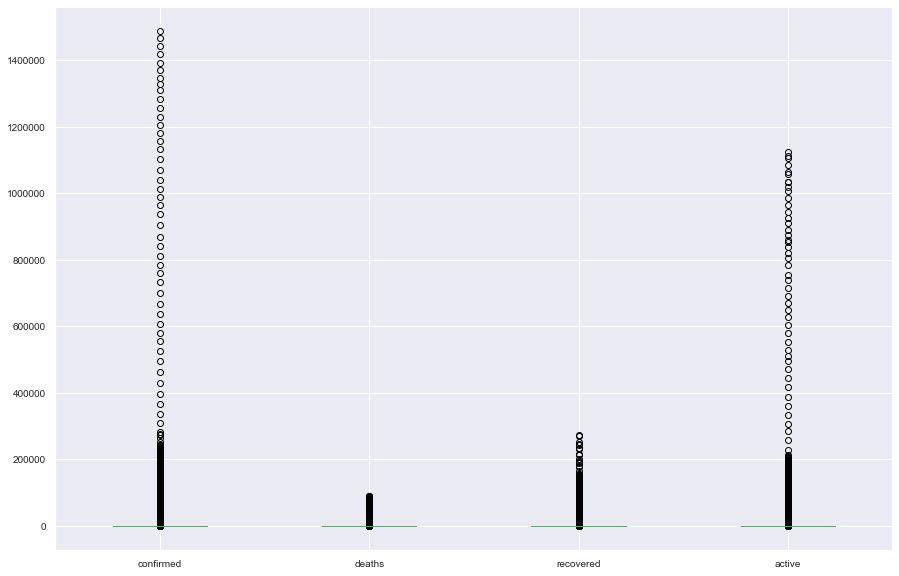

In [17]:
# looking at the plots like this we might want to look at each individual column
gdf[gdf.columns[7:11]].boxplot(figsize = (15,10), fontsize = 10)
plt.show()

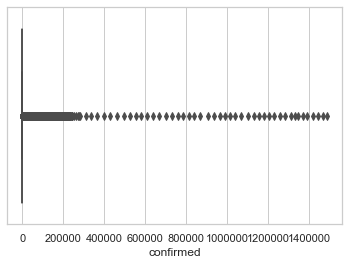

In [18]:
#since this is a build up we are probably not going to see many outliers. 
# might make more sense to just aggregate by country and see if there are countries with no data
sns.set(style="whitegrid")
ax = sns.boxplot(x=gdf["confirmed"])

In [19]:
# I will group by and sum up all the country city combinations
gdf2 = gdf[['country', 'city', 'latitude','longitude','confirmed', 'deaths', 'recovered', 'active']].groupby(['country', 'city', 'latitude','longitude'], as_index = False).agg({'confirmed':'sum'
                                                                                                                   , 'deaths':'sum'
                                                                                                                   , 'recovered':'sum'
                                                                                                                   , 'active':'sum'})

In [20]:
gdf2.head()

country city  latitude  longitude  confirmed  deaths  recovered  active
0  Afghanistan          33.94      67.71     100890    2860      11990   86040
1      Albania          41.15      20.17      32422    1346      18743   12333
2      Algeria          28.03       1.66     168685   17973      68813   81899
3      Andorra          42.55       1.60      34715    1760      14924   18031
4       Angola         -11.20      17.87       1350     100        349     901

In [21]:
#checking for countries with no values reported
pd.set_option('max_rows', None)
gdf2[((gdf2['confirmed'] <=0) & (gdf2['deaths'] <=0) & (gdf2['recovered'] <=0) & (gdf2['active'] <=0))]

country                city  latitude  longitude  \
255   United States of America                        -14.27    -170.13   
280   United States of America               Adams     46.10    -102.53   
294   United States of America      Aleutians East     55.32    -161.97   
295   United States of America      Aleutians West     52.73    -110.41   
300   United States of America               Alger     46.41     -86.60   
310   United States of America               Allen     37.89     -95.30   
349   United States of America              Arthur     41.57    -101.70   
373   United States of America               Avery     36.08     -81.92   
389   United States of America              Banner     41.55    -103.71   
404   United States of America              Barton     37.50     -94.35   
409   United States of America                Bath     38.06     -79.74   
415   United States of America              Baylor     33.62     -99.21   
417   United States of America           Bear Lake     42.28    -111.33   
433   United States of America                Bell     36.73     -83.68   
437   United States of America             Benewah     47.22    -116.66   
438   United States of America             Bennett     43.19    -101.67   
469   United States of America            Billings     47.02    -103.38   
475   United States of America              Blaine     41.91     -99.98   
477   United States of America              Blaine     48.43    -108.96   
480   United States of America               Bland     37.13     -81.14   
486   United States of America               Boise     43.99    -115.73   
501   United States of America              Borden     32.74    -101.43   
505   United States of America           Bottineau     48.79    -100.84   
515   United States of America                Boyd     42.90     -98.76   
536   United States of America         Bristol Bay     58.75    -156.70   
538   United States of America               Bronx     40.85     -73.86   
551   United States of America               Brown     42.43     -99.93   
593   United States of America               Butte     43.73    -113.17   
612   United States of America             Calhoun     33.56     -92.50   
639   United States of America            Campbell     45.77    -100.05   
674   United States of America              Carter     45.52    -104.54   
696   United States of America            Cavalier     48.77     -98.47   
720   United States of America               Chase     40.52    -101.70   
765   United States of America            Chouteau     47.88    -110.44   
790   United States of America               Clark     44.28    -112.35   
822   United States of America          Clearwater     46.67    -115.66   
842   United States of America                Coal     34.59     -96.30   
881   United States of America            Comanche     37.19     -99.27   
891   United States of America                Cook     47.91     -90.53   
933   United States of America            Crockett     30.72    -101.41   
941   United States of America           Culberson     31.45    -104.52   
959   United States of America              Custer     43.68    -103.45   
961   United States of America              Custer     46.25    -105.57   
964   United States of America                Dade     37.43     -93.85   
965   United States of America             Daggett     40.89    -109.51   
976   United States of America             Daniels     48.78    -105.55   
995   United States of America              Dawson     47.27    -104.89   
1014  United States of America             Decatur     39.78    -100.46   
1028  United States of America              Denali     63.67    -150.01   
1029  United States of America                Dent     37.61     -91.51   
1035  United States of America               Deuel     41.11    -102.33   
1040  United States of America           Dickenson     37.13     -82.35   
1041  United States of America              Dick

Drop these values for now, we may end adding thme back in, but not sure what value you they might add. What is interesting is there are some cities that I would expect to have something, but due to reporting or the ability to report they might not have the means. 

In [22]:
gdf3 = gdf2[((gdf2['confirmed'] <=0) & (gdf2['deaths'] <=0) & (gdf2['recovered'] <=0) & (gdf2['active'] <=0))]

In [23]:
# using the latitude and longitude and if both are true dropping the values
# merge and join took a long time to run
gdf['cond1'] = gdf['latitude'].isin(gdf3['latitude'])
gdf['cond2'] = gdf['longitude'].isin(gdf3['longitude'])

In [24]:
# resetting max display, will take forever to run if we don't
pd.set_option('max_rows', 20) 
#dropping cond1 and cond2 - we shouldn't need those
gdf4 = gdf[(gdf['cond1'] == False) | (gdf['cond2'] == False)][gdf.columns[:-2]]

In [25]:
gdf4.head()

country countryCode province city cityCode  latitude  longitude  \
0  Afghanistan          AF                            33.94      67.71   
1  Afghanistan          AF                            33.94      67.71   
2  Afghanistan          AF                            33.94      67.71   
3  Afghanistan          AF                            33.94      67.71   
4  Afghanistan          AF                            33.94      67.71   

   confirmed  deaths  recovered  active       date                   geometry  
0          0       0          0       0 2020-01-22  POINT (67.71000 33.94000)  
1          0       0          0       0 2020-01-23  POINT (67.71000 33.94000)  
2          0       0          0       0 2020-01-24  POINT (67.71000 33.94000)  
3          0       0          0       0 2020-01-25  POINT (67.71000 33.94000)  
4          0       0          0       0 2020-01-26  POINT (67.71000 33.94000)

In [26]:
#looking for bad data in the country, city, province columns, spot checking
pd.set_option('max_rows', None)  #show all values
gdf4.country.value_counts().sort_index()

Afghanistan                           117
Albania                               117
Algeria                               117
Andorra                               117
Angola                                117
Antigua and Barbuda                   117
Argentina                             117
Armenia                               117
Australia                             936
Austria                               117
Azerbaijan                            117
Bahamas                               117
Bahrain                               117
Bangladesh                            117
Barbados                              117
Belarus                               117
Belgium                               117
Belize                                117
Benin                                 117
Bhutan                                117
Bolivia                               117
Bosnia and Herzegovina                117
Botswana                              117
Brazil                            

In [27]:
gdf4.countryCode.value_counts().sort_index()

AD       117
AE       117
AF       117
AG       117
AL       117
AM       117
AO       117
AR       117
AT       117
AU       936
AZ       117
BA       117
BB       117
BD       117
BE       117
BF       117
BG       117
BH       117
BI       117
BJ       117
BN       117
BO       117
BR       117
BS       117
BT       117
BW       117
BY       117
BZ       117
CA      1638
CD       117
CF       117
CG       117
CH       117
CI       117
CL       117
CM       117
CN      3861
CO       117
CR       117
CU       117
CV       117
CY       117
CZ       117
DE       117
DJ       117
DK       351
DM       117
DO       117
DZ       117
EC       117
EE       117
EG       117
EH       117
ER       117
ES       117
ET       117
FI       117
FJ       117
FR      1287
GA       117
GB      1287
GD       117
GE       117
GH       117
GM       117
GN       117
GQ       117
GR       117
GT       117
GW       117
GY       117
HN       117
HR       117
HT       117
HU       117
ID       117
IE       117

In [28]:
gdf4.province.value_counts().sort_index()

                                    21528
Alabama                              7839
Alaska                               1638
Alberta                               117
Anguilla                              117
Anhui                                 117
Arizona                              1755
Arkansas                             8658
Aruba                                 117
Australian Capital Territory          117
Beijing                               117
Bermuda                               117
Bonaire, Sint Eustatius and Saba      117
British Columbia                      117
British Virgin Islands                117
California                           6318
Cayman Islands                        117
Channel Islands                       117
Chongqing                             117
Colorado                             7020
Connecticut                           936
Curacao                               117
Delaware                              351
District of Columbia              

In [29]:
gdf4.city.value_counts().sort_index()

                         31356
Abbeville                  117
Acadia                     117
Accomack                   117
Ada                        117
Adair                      468
Adams                     1170
Addison                    117
Aiken                      117
Aitkin                     117
Alachua                    117
Alamance                   117
Alameda                    117
Alamosa                    117
Albany                     234
Albemarle                  117
Alcona                     117
Alcorn                     117
Alexander                  234
Alexandria                 117
Alfalfa                    117
Allamakee                  117
Allegan                    117
Allegany                   234
Alleghany                  234
Allegheny                  117
Allen                      468
Allendale                  117
Alpena                     117
Alpine                     117
Amador                     117
Amelia                     117
Amherst 

In [30]:
gdf4.cityCode.value_counts().sort_index()

         31005
10001      117
10003      117
10005      117
1001       117
1003       117
1005       117
1007       117
1009       117
1011       117
1013       117
1015       117
1017       117
1019       117
1021       117
1023       117
1025       117
1027       117
1029       117
1031       117
1033       117
1035       117
1037       117
1039       117
1041       117
1043       117
1045       117
1047       117
1049       117
1051       117
1053       117
1055       117
1057       117
1059       117
1061       117
1063       117
1065       117
1067       117
1069       117
1071       117
1073       117
1075       117
1077       117
1079       117
1081       117
1083       117
1085       117
1087       117
1089       117
1091       117
1093       117
1095       117
1097       117
1099       117
11001      117
1101       117
1103       117
1105       117
1107       117
1109       117
1111       117
1113       117
1115       117
1117       117
1119       117
1121       117
1123      

In [31]:
pd.set_option('max_rows', 20) # resetting to smaller output 
# it looks like there are several null values that are populated as blank, update those to be real null values
for i in gdf4.columns[:5]: 
    gdf4[i] = gdf4[i].replace(regex= {'^$':np.NaN})
    c = gdf4[gdf4[i].isna() == True][i].isna().count()
    print('columns {} has {} null values'.format(i, c))

columns country has 0 null values
columns countryCode has 0 null values
columns province has 21528 null values
columns city has 31356 null values
columns cityCode has 31005 null values


In [32]:
# checking for null values in the other column
for i in gdf4.columns[5:]: 
    c = gdf4[gdf4[i].isna() == True][i].isna().count()
    print('columns {} has {} null values'.format(i, c))

columns latitude has 0 null values
columns longitude has 0 null values
columns confirmed has 0 null values
columns deaths has 0 null values
columns recovered has 0 null values
columns active has 0 null values
columns date has 0 null values
columns geometry has 0 null values


* Find duplicates

In [78]:
# going to store the data in sqlite for backup
#sqlite doesn't like dates, so we need to update to string date
gdf4['date'] = gdf4.date.astype('str')

In [98]:
import sqlite3
# we first need to create a table and define the columns and their variable types
query = """
            CREATE TABLE covid_api
            (
                country VARCHAR(50),
                countryCode VARCHAR(50),
                province VARCHAR(50),
                city VARCHAR(50),
                cityCode VARCHAR(50),
                latitude float,
                longitude float,
                confirmed integer,
                deaths integer,
                recovered integer,
                active integer,
                date text
            );"""

In [96]:
query = """
            drop TABLE covid_api
            ;"""

In [99]:
# now we need to create our database or place to store the table
con = sqlite3.connect('dsc_540_project.sqlite') 
# commit, keeps the entire transaction, else it will be rolled back once we log out
con.execute(query)
# excecute the create table statement so we have a table set up
con.commit()

In [104]:
#insert statement, '?' are like the placeholders for the variables
stmt = "INSERT INTO covid_api VALUES(?,?,?,?,?,?,?,?,?,?,?,?)"
# normally in sql you would have the insert statemnt above and then the data below
# doing it like this tells sqlite to insert and then we have the values after the comma
con.executemany(stmt, gdf4[gdf4.columns[:-1]].values.tolist())
con.commit()

In [105]:
# do a quick check for duplicates based on all the columns and the dates
# returns empty so doens't look like there are any duplicates
cursor = con.execute('''Select * 
                        from (
                                Select country ,
                                countryCode,
                                province,
                                city,
                                cityCode,
                                latitude,
                                longitude,
                                confirmed,
                                deaths,
                                recovered,
                                active,
                                date ,
                                count(1) as dup_ck
                                from covid_api
                                group by 1,2,3,4,5,6,7,8,9,10,11,12
                            ) as x
                        where dup_ck >1
                        ''')
rows = cursor.fetchall()
rows

[]

* Conduct Fuzzy Matching

In [106]:
# lets do a fuzzy match on city and province see if there is duplications or odd behaviors 
gdf4.head()

country countryCode province city cityCode  latitude  longitude  \
0  Afghanistan          AF      NaN  NaN      NaN     33.94      67.71   
1  Afghanistan          AF      NaN  NaN      NaN     33.94      67.71   
2  Afghanistan          AF      NaN  NaN      NaN     33.94      67.71   
3  Afghanistan          AF      NaN  NaN      NaN     33.94      67.71   
4  Afghanistan          AF      NaN  NaN      NaN     33.94      67.71   

   confirmed  deaths  recovered  active        date                   geometry  
0          0       0          0       0  2020-01-22  POINT (67.71000 33.94000)  
1          0       0          0       0  2020-01-23  POINT (67.71000 33.94000)  
2          0       0          0       0  2020-01-24  POINT (67.71000 33.94000)  
3          0       0          0       0  2020-01-25  POINT (67.71000 33.94000)  
4          0       0          0       0  2020-01-26  POINT (67.71000 33.94000)

In [226]:
fuzChk = gdf4['province'].dropna().unique()

In [230]:
fuzChk2 = gdf4['city'].dropna().unique()

In [224]:
fuzChk2

array(['Afghanistan-FILL', 'Albania-FILL', 'Algeria-FILL', ...,
       'Yemen-FILL', 'Zambia-FILL', 'Zimbabwe-FILL'], dtype=object)

In [231]:
from Levenshtein import distance
fuzchk3 = pd.DataFrame(columns = ['col_ck', 'other_col', 'distance'])

for i in fuzChk:
    for ii in fuzChk2:
        d = distance(i,ii)
        fuzchk3 =fuzchk3.append([{'col_ck':i,'other_col': ii,'distance': d}])

In [233]:
# sorting the values to see the closest matches
fuzchk3.sort_values(by =['distance'])

col_ck other_col distance
0                             Oregon    Oregon        0
0                             Nevada    Nevada        0
0                           Arkansas  Arkansas        0
0                           Victoria  Victoria        0
0                              Texas     Texas        0
..                               ...       ...      ...
0   Bonaire, Sint Eustatius and Saba      Gulf       31
0   Bonaire, Sint Eustatius and Saba      Hall       31
0   Bonaire, Sint Eustatius and Saba    Kimble       31
0   Bonaire, Sint Eustatius and Saba     Major       31
0   Bonaire, Sint Eustatius and Saba    McCook       32

[230850 rows x 3 columns]

In [235]:
# looking at the 0 distance first
fuzchk3[fuzchk3.distance == 0]

col_ck             other_col distance
0              Victoria              Victoria        0
0               Ontario               Ontario        0
0              Colorado              Colorado        0
0              Oklahoma              Oklahoma        0
0              Arkansas              Arkansas        0
0                  Ohio                  Ohio        0
0                  Iowa                  Iowa        0
0               Indiana               Indiana        0
0           Mississippi           Mississippi        0
0                 Texas                 Texas        0
0            Washington            Washington        0
0              New York              New York        0
0                  Utah                  Utah        0
0                 Idaho                 Idaho        0
0                Nevada                Nevada        0
0                Oregon                Oregon        0
0               Wyoming               Wyoming        0
0              Delaware              Delaware        0
0                Hawaii                Hawaii        0
0  District of Columbia  District of Columbia        0

In [242]:
# check a few starting with my favorite state, make sure there are not dup dates for the same place
pd.set_option('max_rows', None) 
gdf4[(gdf4.city == 'Idaho') & (gdf4.province == 'Idaho')]
# idaho has a city Idaho city verified by googling

country countryCode province   city cityCode  \
30749   United States of America          US    Idaho  Idaho    16049   
34297   United States of America          US    Idaho  Idaho    16049   
36545   United States of America          US    Idaho  Idaho    16049   
40928   United States of America          US    Idaho  Idaho    16049   
45375   United States of America          US    Idaho  Idaho    16049   
46346   United States of America          US    Idaho  Idaho    16049   
49604   United States of America          US    Idaho  Idaho    16049   
53449   United States of America          US    Idaho  Idaho    16049   
57830   United States of America          US    Idaho  Idaho    16049   
61203   United States of America          US    Idaho  Idaho    16049   
62476   United States of America          US    Idaho  Idaho    16049   
66455   United States of America          US    Idaho  Idaho    16049   
69426   United States of America          US    Idaho  Idaho    16049   
73017   United States of America          US    Idaho  Idaho    16049   
77364   United States of America          US    Idaho  Idaho    16049   
78869   United States of America          US    Idaho  Idaho    16049   
84435   United States of America          US    Idaho  Idaho    16049   
86558   United States of America          US    Idaho  Idaho    16049   
91507   United States of America          US    Idaho  Idaho    16049   
94656   United States of America          US    Idaho  Idaho    16049   
97586   United States of America          US    Idaho  Idaho    16049   
98293   United States of America          US    Idaho  Idaho    16049   
102767  United States of America          US    Idaho  Idaho    16049   
105740  United States of America          US    Idaho  Idaho    16049   
110550  United States of America          US    Idaho  Idaho    16049   
111797  United States of America          US    Idaho  Idaho    16049   
115783  United States of America          US    Idaho  Idaho    16049   
118298  United States of America          US    Idaho  Idaho    16049   
123660  United States of America          US    Idaho  Idaho    16049   
127053  United States of America          US    Idaho  Idaho    16049   
130069  United States of America          US    Idaho  Idaho    16049   
133781  United States of America          US    Idaho  Idaho    16049   
136160  United States of America          US    Idaho  Idaho    16049   
140314  United States of America          US    Idaho  Idaho    16049   
141832  United States of America          US    Idaho  Idaho    16049   
145404  United States of America          US    Idaho  Idaho    16049   
148703  United States of America          US    Idaho  Idaho    16049   
151683  United States of America          US    Idaho  Idaho    16049   
155125  United States of America          US    Idaho  Idaho    16049   
158219  United States of America          US    Idaho  Idaho    16049   
162369  United States of America          US    Idaho  Idaho    16049   
165028  United States of America          US    Idaho  Idaho    16049   
168810  United States of America          US    Idaho  Idaho    16049   
172935  United States of America          US    Idaho  Idaho    16049   
176192  United States of America          US    Idaho  Idaho    16049   
179349  United States of America          US    Idaho  Idaho    16049   
181050  United States of America          US    Idaho  Idaho    16049   
184039  United States of America          US    Idaho  Idaho    16049   
186853  United States of America          US    Idaho  Idaho    16049   
190552  United States of America          US    Idaho  Idaho    16049   
192646  United States of America          US    Idaho  Idaho    16049   
198448  United States of America          US    Idaho  Idaho    16049   
202221  United States of America          US    Idaho  Idaho    16049   
205089  United States of America          US    Idaho  Idaho    16049   
207483  Un

In [244]:
# seems okay two different countries
gdf4[(gdf4.city == 'Victoria') | (gdf4.province == 'Victoria')]

country countryCode  province      city cityCode  \
942                    Australia          AU  Victoria       NaN      NaN   
949                    Australia          AU  Victoria       NaN      NaN   
957                    Australia          AU  Victoria       NaN      NaN   
961                    Australia          AU  Victoria       NaN      NaN   
968                    Australia          AU  Victoria       NaN      NaN   
983                    Australia          AU  Victoria       NaN      NaN   
986                    Australia          AU  Victoria       NaN      NaN   
998                    Australia          AU  Victoria       NaN      NaN   
1003                   Australia          AU  Victoria       NaN      NaN   
1009                   Australia          AU  Victoria       NaN      NaN   
1017                   Australia          AU  Victoria       NaN      NaN   
1030                   Australia          AU  Victoria       NaN      NaN   
1038                   Australia          AU  Victoria       NaN      NaN   
1040                   Australia          AU  Victoria       NaN      NaN   
1052                   Australia          AU  Victoria       NaN      NaN   
1060                   Australia          AU  Victoria       NaN      NaN   
1071                   Australia          AU  Victoria       NaN      NaN   
1079                   Australia          AU  Victoria       NaN      NaN   
1081                   Australia          AU  Victoria       NaN      NaN   
1090                   Australia          AU  Victoria       NaN      NaN   
1101                   Australia          AU  Victoria       NaN      NaN   
1109                   Australia          AU  Victoria       NaN      NaN   
1116                   Australia          AU  Victoria       NaN      NaN   
1124                   Australia          AU  Victoria       NaN      NaN   
1129                   Australia          AU  Victoria       NaN      NaN   
1136                   Australia          AU  Victoria       NaN      NaN   
1145                   Australia          AU  Victoria       NaN      NaN   
1159                   Australia          AU  Victoria       NaN      NaN   
1167                   Australia          AU  Victoria       NaN      NaN   
1174                   Australia          AU  Victoria       NaN      NaN   
1177                   Australia          AU  Victoria       NaN      NaN   
1186                   Australia          AU  Victoria       NaN      NaN   
1198                   Australia          AU  Victoria       NaN      NaN   
1207                   Australia          AU  Victoria       NaN      NaN   
1211                   Australia          AU  Victoria       NaN      NaN   
1221                   Australia          AU  Victoria       NaN      NaN   
1227                   Australia          AU  Victoria       NaN      NaN   
1238                   Australia          AU  Victoria       NaN      NaN   
1244                   Australia          AU  Victoria       NaN      NaN   
1251                   Australia          AU  Victoria       NaN      NaN   
1257                   Australia          AU  Victoria       NaN      NaN   
1264                   Australia          AU  Victoria       NaN      NaN   
1273                   Australia          AU  Victoria       NaN      NaN   
1281                   Australia          AU  Victoria       NaN      NaN   
1292                   Australia          AU  Victoria       NaN      NaN   
1297                   Australia          AU  Victoria       NaN      NaN   
1308                   Australia          AU  Victoria       NaN      NaN   
1319                   Australia          AU  Victoria       NaN      NaN   
1322                   Australia          AU  Victoria       NaN      NaN   
1332                   Australia          AU  Victoria       NaN      NaN   
1336                   Australia          AU  Victoria       NaN      NaN   
1344                 

In [245]:
# District of columbia, see next line of code with or we get the same result
gdf4[(gdf4.city == 'District of Columbia') & (gdf4.province == 'District of Columbia')]

country countryCode              province  \
31792   United States of America          US  District of Columbia   
35538   United States of America          US  District of Columbia   
39381   United States of America          US  District of Columbia   
42639   United States of America          US  District of Columbia   
43696   United States of America          US  District of Columbia   
47762   United States of America          US  District of Columbia   
50686   United States of America          US  District of Columbia   
52612   United States of America          US  District of Columbia   
56839   United States of America          US  District of Columbia   
61046   United States of America          US  District of Columbia   
64140   United States of America          US  District of Columbia   
68335   United States of America          US  District of Columbia   
69108   United States of America          US  District of Columbia   
73578   United States of America          US  District of Columbia   
76360   United States of America          US  District of Columbia   
78688   United States of America          US  District of Columbia   
82812   United States of America          US  District of Columbia   
88037   United States of America          US  District of Columbia   
90490   United States of America          US  District of Columbia   
92752   United States of America          US  District of Columbia   
94929   United States of America          US  District of Columbia   
100765  United States of America          US  District of Columbia   
104562  United States of America          US  District of Columbia   
107790  United States of America          US  District of Columbia   
108737  United States of America          US  District of Columbia   
113748  United States of America          US  District of Columbia   
115885  United States of America          US  District of Columbia   
118995  United States of America          US  District of Columbia   
122298  United States of America          US  District of Columbia   
126104  United States of America          US  District of Columbia   
130571  United States of America          US  District of Columbia   
131646  United States of America          US  District of Columbia   
135931  United States of America          US  District of Columbia   
140090  United States of America          US  District of Columbia   
141943  United States of America          US  District of Columbia   
143874  United States of America          US  District of Columbia   
148479  United States of America          US  District of Columbia   
152195  United States of America          US  District of Columbia   
154722  United States of America          US  District of Columbia   
157559  United States of America          US  District of Columbia   
162689  United States of America          US  District of Columbia   
163552  United States of America          US  District of Columbia   
167930  United States of America          US  District of Columbia   
172631  United States of America          US  District of Columbia   
174286  United States of America          US  District of Columbia   
177119  United States of America          US  District of Columbia   
180097  United States of America          US  District of Columbia   
183206  United States of America          US  District of Columbia   
186671  United States of America          US  District of Columbia   
191162  United States of America          US  District of Columbia   
193421  United States of America          US  District of Columbia   
198114  United States of America          US  District of Columbia   
200765  United States of America          US  District of Columbia   
202712  United States of America          US  District of Columbia   
207713  United States of America          US  District of Columbia   
211485  United States of America          US  District of Columbia   
212113  United States of America   

In [246]:
gdf4[(gdf4.city == 'District of Columbia') | (gdf4.province == 'District of Columbia')]

country countryCode              province  \
31792   United States of America          US  District of Columbia   
35538   United States of America          US  District of Columbia   
39381   United States of America          US  District of Columbia   
42639   United States of America          US  District of Columbia   
43696   United States of America          US  District of Columbia   
47762   United States of America          US  District of Columbia   
50686   United States of America          US  District of Columbia   
52612   United States of America          US  District of Columbia   
56839   United States of America          US  District of Columbia   
61046   United States of America          US  District of Columbia   
64140   United States of America          US  District of Columbia   
68335   United States of America          US  District of Columbia   
69108   United States of America          US  District of Columbia   
73578   United States of America          US  District of Columbia   
76360   United States of America          US  District of Columbia   
78688   United States of America          US  District of Columbia   
82812   United States of America          US  District of Columbia   
88037   United States of America          US  District of Columbia   
90490   United States of America          US  District of Columbia   
92752   United States of America          US  District of Columbia   
94929   United States of America          US  District of Columbia   
100765  United States of America          US  District of Columbia   
104562  United States of America          US  District of Columbia   
107790  United States of America          US  District of Columbia   
108737  United States of America          US  District of Columbia   
113748  United States of America          US  District of Columbia   
115885  United States of America          US  District of Columbia   
118995  United States of America          US  District of Columbia   
122298  United States of America          US  District of Columbia   
126104  United States of America          US  District of Columbia   
130571  United States of America          US  District of Columbia   
131646  United States of America          US  District of Columbia   
135931  United States of America          US  District of Columbia   
140090  United States of America          US  District of Columbia   
141943  United States of America          US  District of Columbia   
143874  United States of America          US  District of Columbia   
148479  United States of America          US  District of Columbia   
152195  United States of America          US  District of Columbia   
154722  United States of America          US  District of Columbia   
157559  United States of America          US  District of Columbia   
162689  United States of America          US  District of Columbia   
163552  United States of America          US  District of Columbia   
167930  United States of America          US  District of Columbia   
172631  United States of America          US  District of Columbia   
174286  United States of America          US  District of Columbia   
177119  United States of America          US  District of Columbia   
180097  United States of America          US  District of Columbia   
183206  United States of America          US  District of Columbia   
186671  United States of America          US  District of Columbia   
191162  United States of America          US  District of Columbia   
193421  United States of America          US  District of Columbia   
198114  United States of America          US  District of Columbia   
200765  United States of America          US  District of Columbia   
202712  United States of America          US  District of Columbia   
207713  United States of America          US  District of Columbia   
211485  United States of America          US  District of Columbia   
212113  United States of America   

In [247]:
#checking distance equal to 1
fuzchk3[fuzchk3.distance == 1]

col_ck   other_col distance
0  St Martin  St. Martin        1
0   Arkansas     Aransas        1

In [250]:
# two different countries
gdf4[(gdf4.province == 'St Martin') | (gdf4.city == 'St. Martin') ]

country countryCode   province        city cityCode  \
13226                     France          FR  St Martin         NaN      NaN   
13242                     France          FR  St Martin         NaN      NaN   
13245                     France          FR  St Martin         NaN      NaN   
13263                     France          FR  St Martin         NaN      NaN   
13267                     France          FR  St Martin         NaN      NaN   
13278                     France          FR  St Martin         NaN      NaN   
13296                     France          FR  St Martin         NaN      NaN   
13303                     France          FR  St Martin         NaN      NaN   
13312                     France          FR  St Martin         NaN      NaN   
13323                     France          FR  St Martin         NaN      NaN   
13332                     France          FR  St Martin         NaN      NaN   
13346                     France          FR  St Martin         NaN      NaN   
13355                     France          FR  St Martin         NaN      NaN   
13365                     France          FR  St Martin         NaN      NaN   
13377                     France          FR  St Martin         NaN      NaN   
13394                     France          FR  St Martin         NaN      NaN   
13401                     France          FR  St Martin         NaN      NaN   
13415                     France          FR  St Martin         NaN      NaN   
13422                     France          FR  St Martin         NaN      NaN   
13434                     France          FR  St Martin         NaN      NaN   
13442                     France          FR  St Martin         NaN      NaN   
13458                     France          FR  St Martin         NaN      NaN   
13463                     France          FR  St Martin         NaN      NaN   
13476                     France          FR  St Martin         NaN      NaN   
13490                     France          FR  St Martin         NaN      NaN   
13498                     France          FR  St Martin         NaN      NaN   
13507                     France          FR  St Martin         NaN      NaN   
13520                     France          FR  St Martin         NaN      NaN   
13535                     France          FR  St Martin         NaN      NaN   
13543                     France          FR  St Martin         NaN      NaN   
13554                     France          FR  St Martin         NaN      NaN   
13568                     France          FR  St Martin         NaN      NaN   
13576                     France          FR  St Martin         NaN      NaN   
13589                     France          FR  St Martin         NaN      NaN   
13605                     France          FR  St Martin         NaN      NaN   
13610                     France          FR  St Martin         NaN      NaN   
13620                     France          FR  St Martin         NaN      NaN   
13634                     France          FR  St Martin         NaN      NaN   
13641                     France          FR  St Martin         NaN      NaN   
13652                     France          FR  St Martin         NaN      NaN   
13671                     France          FR  St Martin         NaN      NaN   
13675                     France          FR  St Martin         NaN      NaN   
13688                     France          FR  St Martin         NaN      NaN   
13704                     France          FR  St Martin         NaN      NaN   
13710                     France          FR  St Martin         NaN      NaN   
13724                     France          FR  St Martin         NaN      NaN   
13737                     France          FR  St Martin         NaN      NaN   
13738                     France          FR  St Martin         NaN      NaN   
13759                     France          FR  St Martin         NaN      NaN   
13769                    

In [253]:
# different places seems okay
gdf4[(gdf4.province == 'Arkansas') | (gdf4.city == 'Aransas') ]

country countryCode  province          city cityCode  \
29840   United States of America          US  Arkansas      Randolph     5121   
29855   United States of America          US  Arkansas         Grant     5053   
29901   United States of America          US  Arkansas        Benton     5007   
30024   United States of America          US  Arkansas        Baxter     5005   
30028   United States of America          US  Arkansas    Hot Spring     5059   
30037   United States of America          US  Arkansas        Nevada     5099   
30048   United States of America          US  Arkansas      Lawrence     5075   
30072   United States of America          US  Arkansas     Sebastian     5131   
30080   United States of America          US  Arkansas        Chicot     5017   
30129   United States of America          US  Arkansas        Lonoke     5085   
30180   United States of America          US  Arkansas      Cleburne     5023   
30246   United States of America          US     Texas       Aransas    48007   
30248   United States of America          US  Arkansas        Howard     5061   
30251   United States of America          US  Arkansas        Saline     5125   
30264   United States of America          US  Arkansas     Hempstead     5057   
30290   United States of America          US  Arkansas        Searcy     5129   
30400   United States of America          US  Arkansas         Stone     5137   
30435   United States of America          US  Arkansas        Ashley     5003   
30494   United States of America          US  Arkansas          Clay     5021   
30503   United States of America          US  Arkansas         Union     5139   
30614   United States of America          US  Arkansas          Pike     5109   
30672   United States of America          US  Arkansas     Craighead     5031   
30776   United States of America          US  Arkansas        Dallas     5039   
30812   United States of America          US  Arkansas       Johnson     5071   
30918   United States of America          US  Arkansas       Garland     5051   
30920   United States of America          US  Arkansas       Pulaski     5119   
30963   United States of America          US  Arkansas       Jackson     5067   
31031   United States of America          US  Arkansas          Yell     5149   
31046   United States of America          US  Arkansas  Little River     5081   
31078   United States of America          US  Arkansas         Boone     5009   
31208   United States of America          US  Arkansas        Greene     5055   
31220   United States of America          US  Arkansas         Scott     5127   
31285   United States of America          US  Arkansas         White     5145   
31307   United States of America          US  Arkansas        Monroe     5095   
31322   United States of America          US  Arkansas      Phillips     5107   
31323   United States of America          US  Arkansas     Cleveland     5025   
31329   United States of America          US  Arkansas   Mississippi     5093   
31373   United States of America          US  Arkansas          Pope     5115   
31427   United States of America          US  Arkansas          Polk     5113   
31467   United States of America          US  Arkansas      Arkansas     5001   
31488   United States of America          US  Arkansas       Prairie     5117   
31537   United States of America          US  Arkansas         Desha     5041   
31614   United States of America          US  Arkansas        Conway     5029   
31692   United States of America          US  Arkansas        Marion     5089   
31694   United States of America          US  Arkansas        Fulton     5049   
31698   United States of America          US  Arkansas    Montgomery     5097   
31741   United States of America          US  Arkansas        Newton     5101   
31786   United States of America          US  Arkansas        Miller     5091   
31810   United States of America          US  Arkansas  

In [254]:
fuzchk3[fuzchk3.distance == 3]

col_ck     other_col distance
0      Tasmania      Skamania        3
0       Ontario         Otero        3
0       Ontario        Antrim        3
0      Manitoba      Mariposa        3
0      Manitoba     Manitowoc        3
0      Manitoba      Minidoka        3
0      Manitoba      Maricopa        3
0         Yukon         Eaton        3
0         Yukon        Fulton        3
0         Yukon          Yuma        3
0         Yukon          Lyon        3
0         Yukon         Macon        3
0         Yukon         Dukes        3
0         Yukon        Hudson        3
0         Yukon         Union        3
0         Yukon          Iron        3
0         Yukon         Yazoo        3
0         Yukon         Aiken        3
0         Yukon         Teton        3
0         Yukon          Yuba        3
0         Yukon         Mason        3
0         Yukon          Dunn        3
0         Yukon          Yolo        3
0         Yukon       Yankton        3
0         Yukon         Upson        3
0         Yukon          Elko        3
0         Yukon          Leon        3
0         Yukon        Yadkin        3
0         Yukon         Obion        3
0         Yukon        Loudon        3
0         Yukon         Bacon        3
0         Yukon         Dixon        3
0         Yukon         Anson        3
0       Alberta       Liberty        3
0       Alberta        Iberia        3
0       Alberta       Roberts        3
0       Alberta       Colbert        3
0       Alberta        Alpena        3
0        Quebec        Pueblo        3
0        Quebec        Nueces        3
0        Quebec         Weber        3
0        Fujian        Fulton        3
0        Fujian        Furnas        3
0         Jilin         Allen        3
0         Jilin         Giles        3
0         Jilin        Hamlin        3
0         Jilin        Saline        3
0         Jilin        Collin        3
0         Jilin         Irwin        3
0         Jilin          Linn        3
0         Jilin         Vilas        3
0         Jilin         Mills        3
0         Jilin         Aiken        3
0         Jilin       Mifflin        3
0         Jilin        Wilson        3
0         Jilin          Will        3
0         Jilin         Pepin        3
0         Jilin         Marin        3
0         Jilin          Hill        3
0         Jilin         Ellis        3
0         Jilin         Milam        3
0         Jilin         Dixie        3
0         Jilin         Nolan        3
0         Jilin        Pitkin        3
0         Jilin        Dillon        3
0         Jilin         Swain        3
0         Jilin        Aitkin        3
0         Jilin         Riley        3
0         Jilin          Gila        3
0         Jilin        Duplin        3
0         Jilin          Winn        3
0         Jilin         Dixon        3
0         Hebei           Lee        3
0         Hebei          Hale        3
0         Hebei         Dewey        3
0         Hebei         Henry        3
0         Hebei          Hoke        3
0         Hebei          Hyde        3
0         Hebei           Bee        3
0         Hebei          Webb        3
0         Hebei         Lemhi        3
0         Hebei         Heard        3
0         Hebei         Deuel        3
0         Gansu         Grant        3
0         Gansu         Garza        3
0         Gansu          Hays        3
0         Gansu          Kane        3
0         Gansu          Cass        3
0         Gansu         Gates        3
0         Gansu         Grand        3
0         Gansu         Galax        3
0         Gansu          Lane        3
0         Gansu          Hand        3
0         Gansu         Evans        3
0         Gansu          Dane        3
0         Gansu          Nash        3
0         Gansu         Nance        3
0         Gansu          Gage        3
0         Gansu        Nassau        3
0         Gansu         Rains        3
0         Gansu         Walsh        3
0         Gansu         Taney  

In [255]:
fuzchk3[fuzchk3.distance == 4]

col_ck     other_col distance
0       Tasmania       Tarrant        4
0       Tasmania        Cassia        4
0       Tasmania          Tama        4
0       Tasmania       Cambria        4
0       Tasmania       Passaic        4
0       Tasmania      Washakie        4
0       Victoria      Brazoria        4
0       Victoria       Ventura        4
0       Victoria       Emporia        4
0       Victoria        Vinton        4
0       Victoria         Ector        4
0       Victoria        Peoria        4
0        Ontario        Marion        4
0        Ontario          Ohio        4
0        Ontario         Stark        4
0        Ontario        Starke        4
0        Ontario        Ottawa        4
0        Ontario         Starr        4
0        Ontario         Marin        4
0        Ontario        Otsego        4
0        Ontario       Navarro        4
0        Ontario          Frio        4
0        Ontario       Guthrie        4
0        Ontario       Clarion        4
0       Manitoba        Marion        4
0       Manitoba       Madison        4
0       Manitoba        Panola        4
0       Manitoba       Yankton        4
0       Manitoba      Manistee        4
0       Manitoba       Manatee        4
0       Manitoba       Montour        4
0       Manitoba        Monona        4
0       Manitoba      Moniteau        4
0       Manitoba      Saratoga        4
0          Yukon        Marion        4
0          Yukon        Benton        4
0          Yukon         Duval        4
0          Yukon       Jackson        4
0          Yukon         Allen        4
0          Yukon          Coos        4
0          Yukon         Butte        4
0          Yukon          Lake        4
0          Yukon        Nelson        4
0          Yukon        Emmons        4
0          Yukon        Carbon        4
0          Yukon         Surry        4
0          Yukon          Rusk        4
0          Yukon          Coke        4
0          Yukon         Logan        4
0          Yukon         Baker        4
0          Yukon          Wood        4
0          Yukon          Knox        4
0          Yukon        Vernon        4
0          Yukon         Boone        4
0          Yukon         Curry        4
0          Yukon          Ohio        4
0          Yukon       Lumpkin        4
0          Yukon         Irwin        4
0          Yukon          Linn        4
0          Yukon          Pike        4
0          Yukon         Tulsa        4
0          Yukon        Gaston        4
0          Yukon       Houston        4
0          Yukon         Rabun        4
0          Yukon         Brown        4
0          Yukon         Burke        4
0          Yukon         Stone        4
0          Yukon         Green        4
0          Yukon         Young        4
0          Yukon        Wilkin        4
0          Yukon         Lucas        4
0          Yukon          Hunt        4
0          Yukon         Bucks        4
0          Yukon          York        4
0          Yukon        Wilson        4
0          Yukon        Tucker        4
0          Yukon          Hoke        4
0          Yukon        Tipton        4
0          Yukon        Dakota        4
0          Yukon         Rowan        4
0          Yukon        Winona        4
0          Yukon        Dubois        4
0          Yukon       Dunklin        4
0          Yukon        Newton        4
0          Yukon          Gulf        4
0          Yukon         Yates        4
0          Yukon         Bryan        4
0          Yukon           Elk        4
0          Yukon          Wake        4
0          Yukon          Owen        4
0          Yukon          Yell        4
0          Yukon          Hood        4
0          Yukon          Long        4
0          Yukon         Pepin        4
0          Yukon        Dawson        4
0          Yukon         Marin        4
0          Yukon        Kenton        4
0          Yukon        Alcorn        4
0          Yukon        Walton        4
0         

In [256]:
# at this point nothing stands out as bad looks like it is ready to go